In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import paths
from data_utils import (
    load_yaml_file,
    load_data,
    split_data,
    scale_data,
)
from vae.vae_utils import (
    instantiate_vae_model,
    train_vae,
    get_prior_samples,
)

In [2]:
def visualize_multiple_tsne(
    dataset_names: list,
    perc_list: list,
    model_name: str,
    save_dir: str,
    max_samples: int = 1000,
    train_epochs: int = 1000,
) -> None:
    """
    Visualize t-SNE for multiple datasets and percentages in a 5x4 grid of subplots.

    Args:
        dataset_names (list): List of dataset names to process.
        perc_list (list): List of percentages to process for each dataset.
        model_name (str): Name of the VAE model to use.
        save_dir (str): Directory path to save the resulting plots.
        max_samples (int): Maximum number of samples to use in the t-SNE plots.
    """
    fig, axes = plt.subplots(len(perc_list), len(dataset_names), figsize=(20, 25))
    
    total_iterations = len(dataset_names) * len(perc_list)
    iteration_count = 0
    
    for i, dataset_name in enumerate(dataset_names):
        for j, perc in enumerate(perc_list):
            iteration_count += 1
            print(f"Processing {dataset_name} at {perc}%... ({iteration_count}/{total_iterations})")
            
            # Generate dataset filename
            dataset_filename = f"{dataset_name}_subsampled_train_perc_{perc}"
            
            # Load data, train the model, and visualize t-SNE for the current dataset and percentage
            scenario_name = f"{dataset_name} | p = {perc}"
            dataset_path = os.path.join(paths.DATASETS_DIR, dataset_filename)
            
            # Load data
            data = load_data(data_dir=paths.DATASETS_DIR, dataset=dataset_filename)
            
            # Split data
            train_data, valid_data = split_data(data, valid_perc=0.1, shuffle=True)
            
            # Scale data
            scaled_train_data, _, scaler = scale_data(train_data, valid_data)
            
            # Load VAE model and generate prior samples
            _, sequence_length, feature_dim = scaled_train_data.shape
            hyperparameters = load_yaml_file(paths.HYPERPARAMETERS_FILE_PATH)[model_name]
            vae_model = instantiate_vae_model(
                vae_type=model_name,
                sequence_length=sequence_length,
                feature_dim=feature_dim,
                **hyperparameters,
            )
            
            # Train the model
            train_vae(vae=vae_model, train_data=scaled_train_data, max_epochs=train_epochs, verbose=0)
            
            # Generate prior samples
            prior_samples = get_prior_samples(vae_model, num_samples=train_data.shape[0])
            
            samples1 = scaled_train_data
            samples2 = prior_samples
            samples1_2d = np.mean(samples1, axis=2)
            samples2_2d = np.mean(samples2, axis=2)

            used_samples = min(samples1_2d.shape[0], max_samples)

            # Combine the original and generated samples
            combined_samples = np.vstack(
                [samples1_2d[:used_samples], samples2_2d[:used_samples]]
            )

            # Compute the t-SNE of the combined samples
            tsne = TSNE(n_components=2, perplexity=40, n_iter=300, random_state=42)
            tsne_samples = tsne.fit_transform(combined_samples)

            # Create a DataFrame for the t-SNE samples
            tsne_df = pd.DataFrame(
                {
                    "tsne_1": tsne_samples[:, 0],
                    "tsne_2": tsne_samples[:, 1],
                    "sample_type": ["Original"] * used_samples
                    + ["Generated (Prior)"] * used_samples,
                }
            )
            
            # Plot the t-SNE samples in the corresponding subplot
            ax = axes[j, i]
            for sample_type, color in zip(["Original", "Generated (Prior)"], ["red", "blue"]):
                indices = tsne_df["sample_type"] == sample_type
                ax.scatter(
                    tsne_df.loc[indices, "tsne_1"],
                    tsne_df.loc[indices, "tsne_2"],
                    color=color,
                    alpha=0.5,
                    s=50,
                )
            ax.set_title(f"{scenario_name}")

    # Set the overall title for the plot
    plt.suptitle("TimeVAE_Pytorch t-SNE plot", fontsize=20)

    # Adjust layout and save the entire figure
    plt.tight_layout(rect=[0, 0, 1, 0.98])
    os.makedirs(save_dir, exist_ok=True)
    plt.savefig(os.path.join(save_dir, "tsne_grid.png"))
    print(f"All plots saved to {save_dir}")
    plt.show()

Processing air at 2%... (1/20)


Processing air at 5%... (2/20)
Processing air at 10%... (3/20)
Processing air at 20%... (4/20)
Processing air at 100%... (5/20)
Processing energy at 2%... (6/20)
Processing energy at 5%... (7/20)
Processing energy at 10%... (8/20)
Processing energy at 20%... (9/20)
Processing energy at 100%... (10/20)
Processing sine at 2%... (11/20)
Processing sine at 5%... (12/20)
Processing sine at 10%... (13/20)
Processing sine at 20%... (14/20)
Processing sine at 100%... (15/20)
Processing stockv at 2%... (16/20)
Processing stockv at 5%... (17/20)
Processing stockv at 10%... (18/20)
Processing stockv at 20%... (19/20)
Processing stockv at 100%... (20/20)
All plots saved to c:\Users\wangy\projects\timeVAE-pytorch\outputs\tsne\tsne_plots


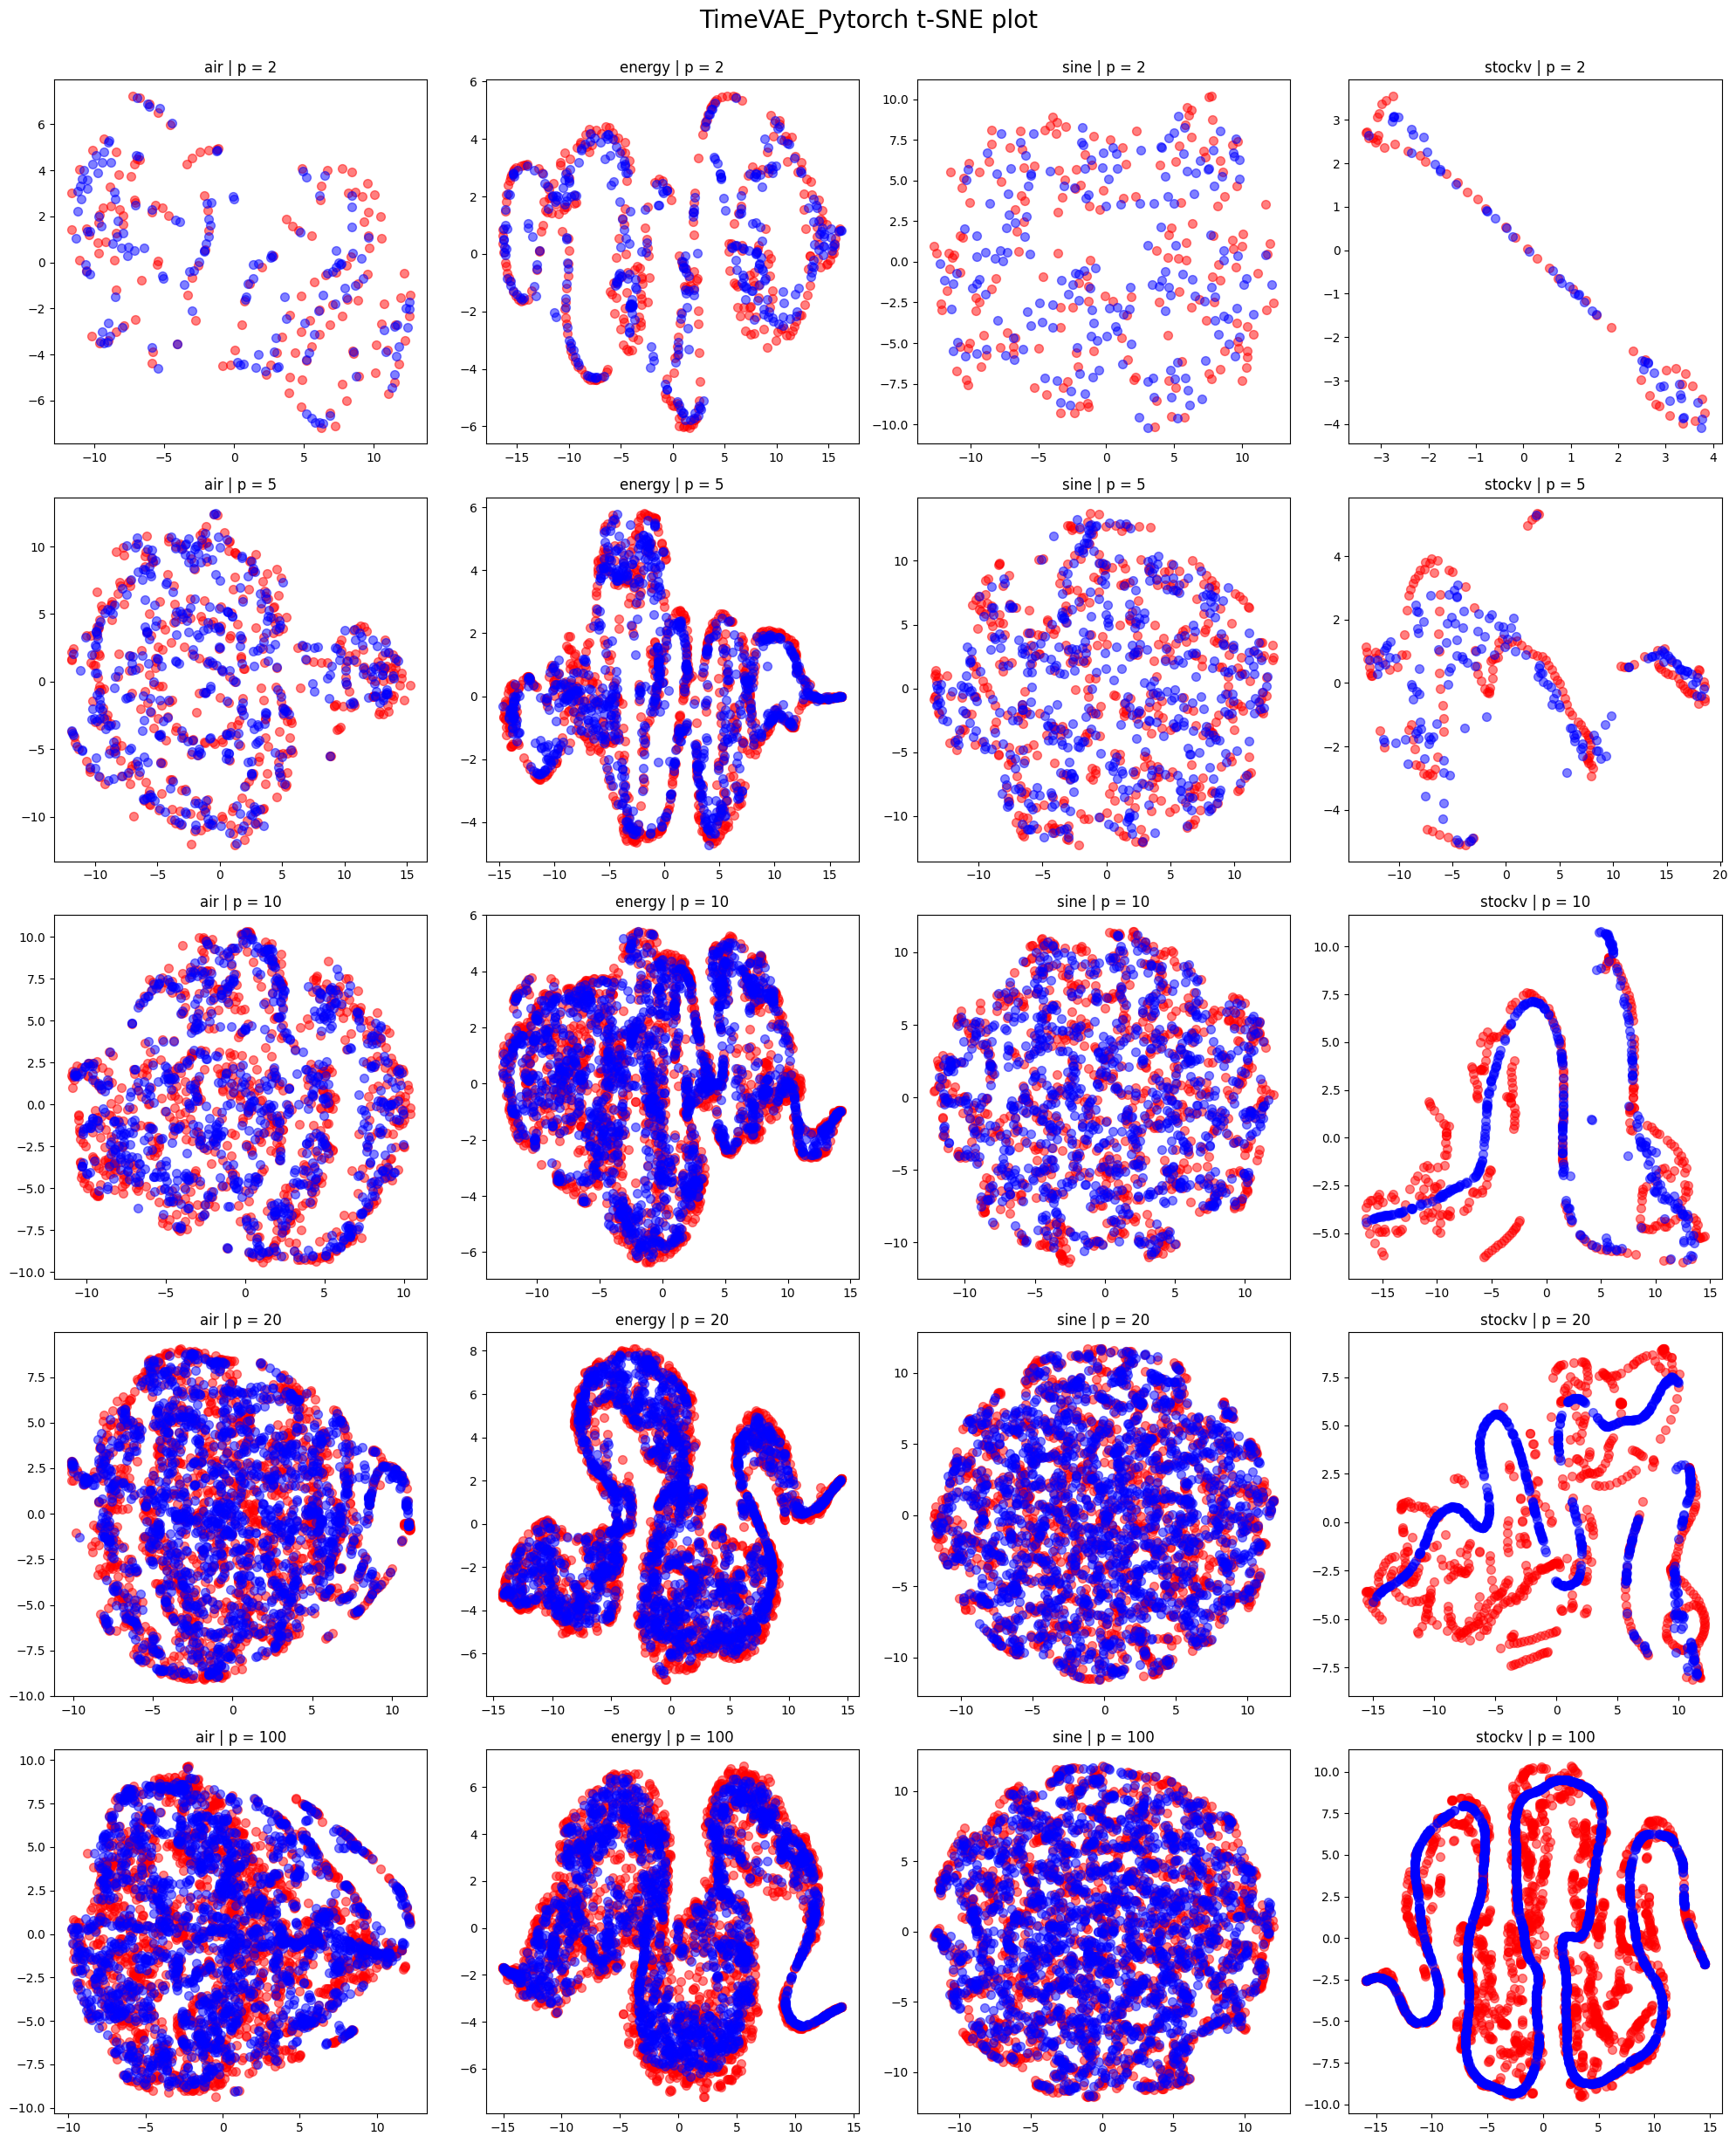

In [3]:
dataset_names = ["air", "energy", "sine", "stockv"]
perc_list = [2, 5, 10, 20, 100]
model_name = "timeVAE"
save_dir = os.path.join(paths.TSNE_DIR, "tsne_plots")

visualize_multiple_tsne(
    dataset_names=dataset_names,
    perc_list=perc_list,
    model_name=model_name,
    save_dir=save_dir,
    max_samples=2000,
    train_epochs=1000,
)